In [254]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width=10, repr.plot.height=6, dpi=96)

# STATS 504
## Week 6: Solar weather prediction and GLMs

This week we will wrap up our project on solar weather data. We will 

Here is the code you should run to follow today's lecture:

In [393]:
library(tidyverse)
library(lubridate)
library(tidymodels)
goes_daily <- read_csv('https://github.com/terhorst/stats504/raw/main/lectures/week5/goes_daily.csv.gz') %>% 
    mutate(Date = make_date(year, month, day)) %>% 
    group_by(Date) %>% summarize(across(flux1:flux2, \(x) mean(x, na.rm=T))) %>% 
    select(Date, flux1, flux2)
combined_flares <- read_csv('https://github.com/terhorst/stats504/raw/main/lectures/week6/combined_flares.csv.gz')

Rows: 8825 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): sat
dbl (5): year, month, day, flux1, flux2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 320177 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Source, XrayClass
dbl  (1): XrayIntensity
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Predicting solar flare events
- As we have seen, solar flare events are capable of causing severe damage to technology:
    - Cause large scale power outages;
    - Disruption radio communications (including GPS);
    - Damage/destroy undersea comminucations cables, 
    - Knock satellites offline.
- There's a lot of interest in being able to predict when they will happen.

## Data on solar flare events
There are several [different ways](https://www.ngdc.noaa.gov/stp/solar/solarflares.html) to measure solar flares:
   1. Direct observation. Observatories train telescopes on the sun and visually observe flare events.
   2. X-Ray data. Flares are defined as a particular combination of events in the raw X-Ray data.

In [3]:
source('read_goes.R')
1980:2016 %>% map_dfr(\(year) read_goes_file(paste0('goes/goes-xrs-report_', year, '.txt.gz'))) %>%
    select(Year, Month, Day, StartTime, EndTime, XrayClass, XrayIntensity) %>% 
    mutate(Year = Year + ifelse(Year > 20, 1900, 2000), Source="GOES") ->
    goes_flares

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

In [5]:
1980:2010 %>% map_dfr(\(year) read_goes_file(paste0('h_alpha/events/', year, '/flare-events_', year, '.txt.gz'))) %>%
    select(Year, Month, Day, StartTime, EndTime, XrayClass, XrayIntensity) %>% 
    mutate(Year = Year + ifelse(Year > 20, 1900, 2000), Source="H_alpha") ->
    h_alpha_flares

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

In [387]:
combined_flares <- bind_rows(goes_flares, h_alpha_flares) %>%
    mutate(Date = make_date(Year, Month, Day)) %>% 
    select(Date, Source, XrayClass, XrayIntensity) 

In [392]:
# write_csv(combined_flares, 'combined_flares.csv.gz')
combined_flares <- read_csv('https://github.com/terhorst/stats504/raw/main/lectures/week6/combined_flares.csv.gz')

Rows: 320177 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Source, XrayClass
dbl  (1): XrayIntensity
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


How do our two sources of data ($H_\alpha$ and GOES) compare?

Warning message:
“Removed 3589 rows containing missing values (`geom_point()`).”


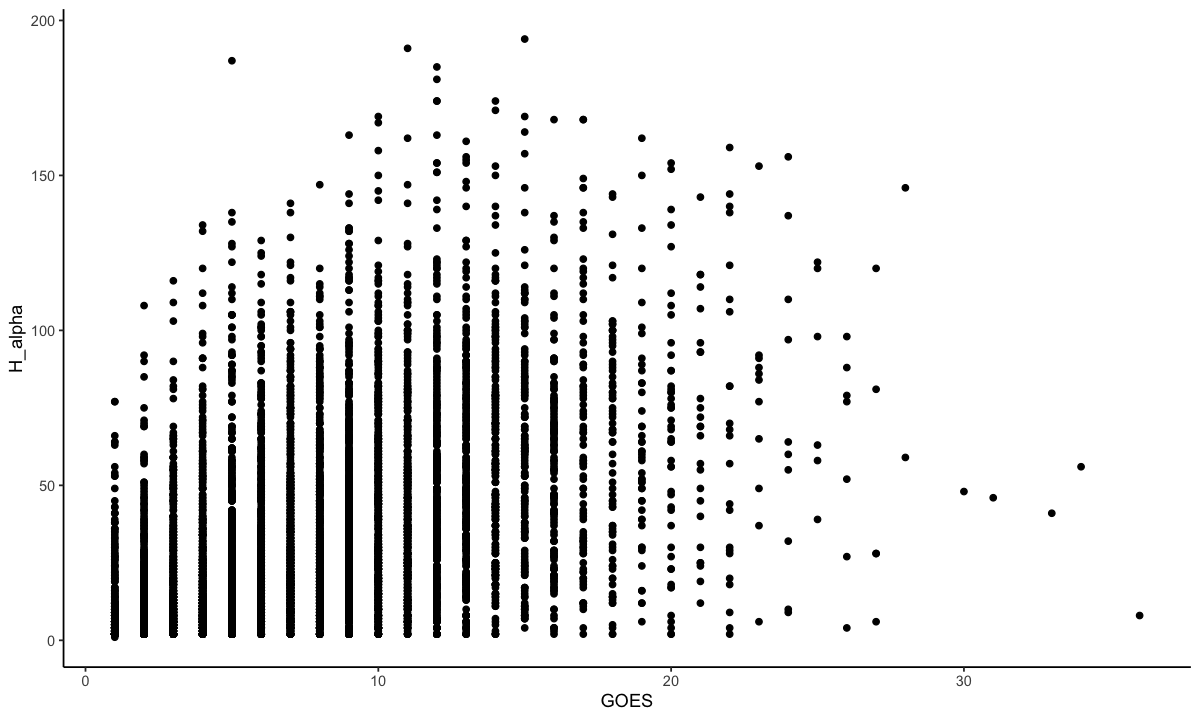

In [7]:
combined_flares %>% count(Date, Source) %>% pivot_wider(names_from=Source, values_from=n) %>% 
    ggplot + geom_point(aes(x=GOES, y=H_alpha))

In [8]:
combined_flares %>% count(Date, Source) %>% pivot_wider(names_from=Source, values_from=n) %>% 
    lm(GOES ~ H_alpha, data=.) %>% summary


Call:
lm(formula = GOES ~ H_alpha, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9779  -2.8925  -0.5747   2.3438  30.1360 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.277930   0.068817   76.69   <2e-16 ***
H_alpha     0.073262   0.001542   47.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.105 on 7532 degrees of freedom
  (3589 observations deleted due to missingness)
Multiple R-squared:  0.2305,	Adjusted R-squared:  0.2304 
F-statistic:  2256 on 1 and 7532 DF,  p-value: < 2.2e-16


Warning message:
“Removed 38 rows containing non-finite values (`stat_count()`).”


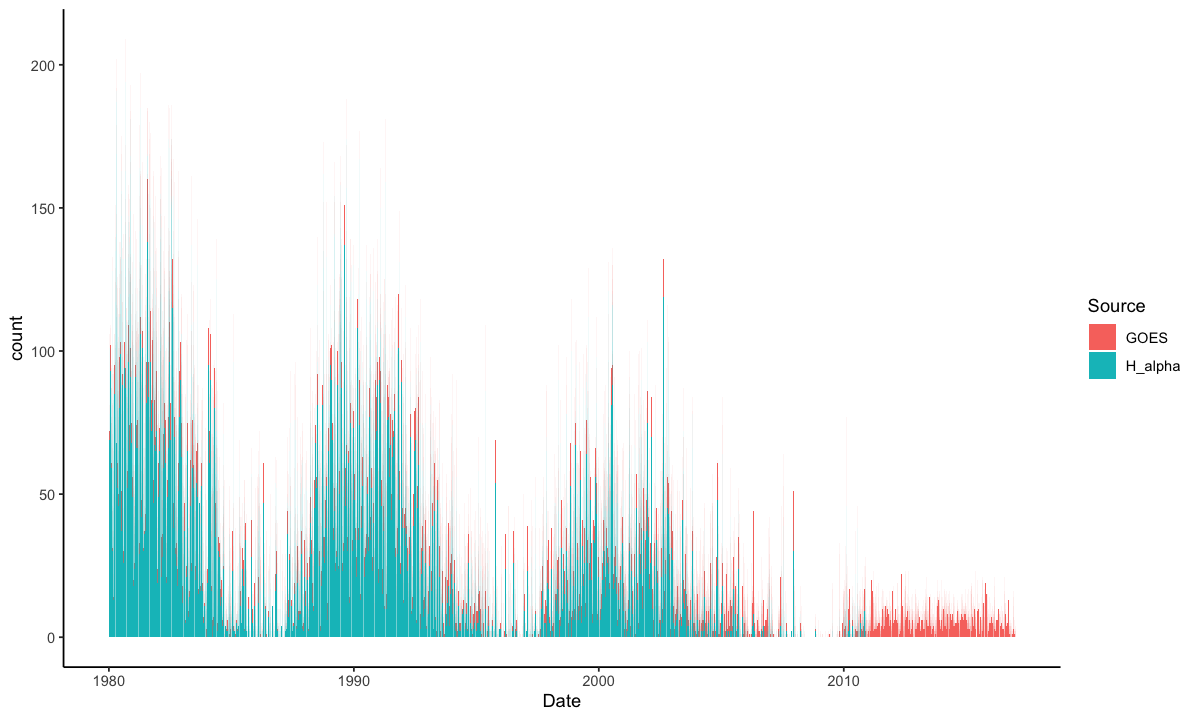

In [9]:
combined_flares %>% 
    ggplot + geom_bar(aes(x = Date, fill = Source))

In [91]:
goes_daily <- read_csv('https://github.com/terhorst/stats504/raw/main/lectures/week5/goes_daily.csv.gz')

Rows: 8825 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): sat
dbl (5): year, month, day, flux1, flux2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [100]:
goes_daily %>% mutate(Date = make_date(year, month, day)) %>% 
    left_join(count(combined_flares, Date)) %>% 
    glm(n ~ lag(log10(flux1)) + lag(log10(flux2)), data=., family='poisson') %>% 
    summary

Joining with `by = join_by(Date)`



Call:
glm(formula = n ~ lag(log10(flux1)) + lag(log10(flux2)), family = "poisson", 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.0434  -1.6624  -0.6581   0.6927  13.9725  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        5.503194   0.057037  96.484   <2e-16 ***
lag(log10(flux1)) -0.003338   0.013251  -0.252    0.801    
lag(log10(flux2))  0.453033   0.011362  39.874   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 22210  on 4462  degrees of freedom
Residual deviance: 18497  on 4460  degrees of freedom
  (4362 observations deleted due to missingness)
AIC: 33731

Number of Fisher Scoring iterations: 5


## Predicting X-class solar flares
- Recall that X-class solar flares are the most intense and have the greatest potential to be disruptive.
- Can we predict whether an X-class flare will occur given GOES data in the days leading up to it?

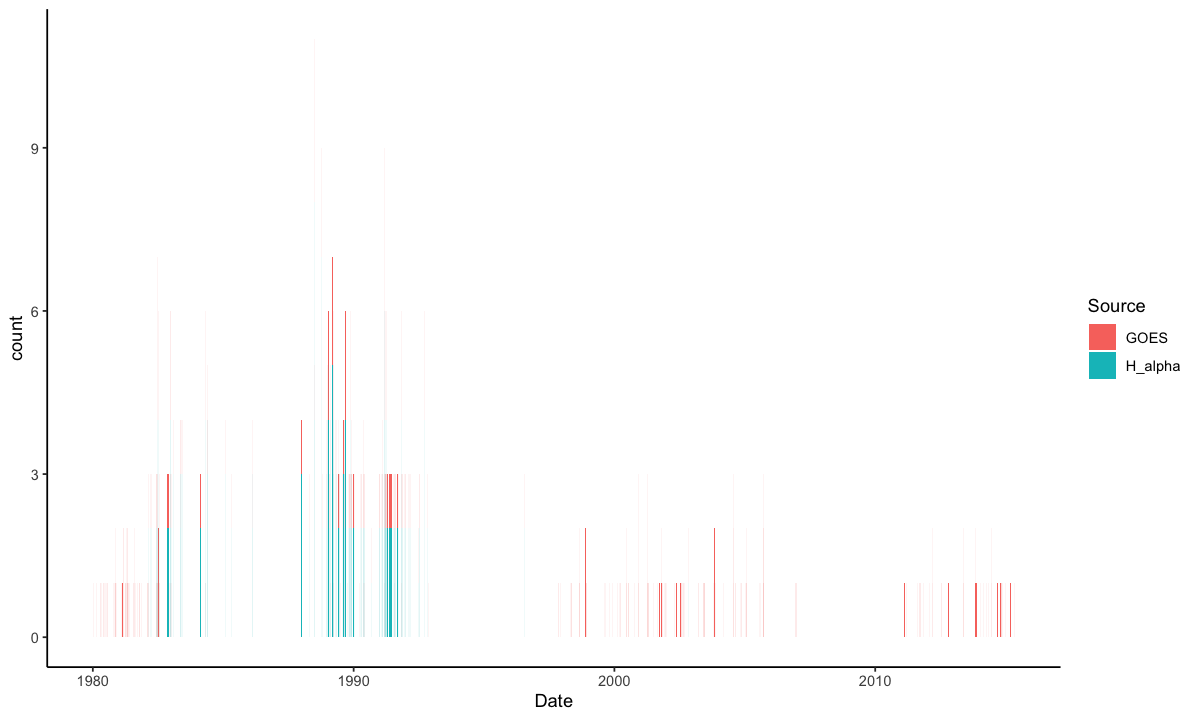

In [201]:
combined_flares %>% filter(XrayClass == "X") %>% 
    ggplot + geom_bar(aes(x = Date, fill = Source))

Let's create a dataset that we can use to train a binary classifier. For each day, we need a variable indicating whether or not an X-class flare happened. Then we'll join it with daily GOES data from a previous lecture.

In [343]:
library(tsibble)
X_daily <- combined_flares %>% filter(XrayClass == "X") %>% distinct(Date) %>% mutate(X_flare=T) %>% 
    as_tsibble %>% fill_gaps(X_flare=F) 

Using `Date` as index variable.


Next we will create the data frame used to run the classification algorithm.

In [344]:
cls_df <- goes_daily %>% as_tsibble %>% mutate(across(flux1:flux2, lag)) %>% 
    left_join(X_daily) %>% as_tibble %>% 
    select(X_flare, flux1, flux2) %>% 
    drop_na(X_flare)

summary(cls_df)

Using `Date` as index variable.
Joining with `by = join_by(Date)`


  X_flare            flux1              flux2         
 Mode :logical   Min.   :0.00e+00   Min.   :0.00e+00  
 FALSE:3714      1st Qu.:0.00e+00   1st Qu.:0.00e+00  
 TRUE :58        Median :1.00e-07   Median :0.00e+00  
                 Mean   :6.00e-07   Mean   :1.00e-07  
                 3rd Qu.:6.00e-07   3rd Qu.:0.00e+00  
                 Max.   :4.87e-05   Max.   :2.99e-05  
                 NA's   :1          NA's   :1         

## Logistic regression
- We have already seen examples of fitting a *regression* function

$$f(\text{data}) \to \text{(real-valued outcome)}$$


In [345]:
lm(log(price) ~ log(carat), data=diamonds) %>% summary


Call:
lm(formula = log(price) ~ log(carat), data = diamonds)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50833 -0.16951 -0.00591  0.16637  1.33793 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.448661   0.001365  6190.9   <2e-16 ***
log(carat)  1.675817   0.001934   866.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2627 on 53938 degrees of freedom
Multiple R-squared:  0.933,	Adjusted R-squared:  0.933 
F-statistic: 7.51e+05 on 1 and 53938 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


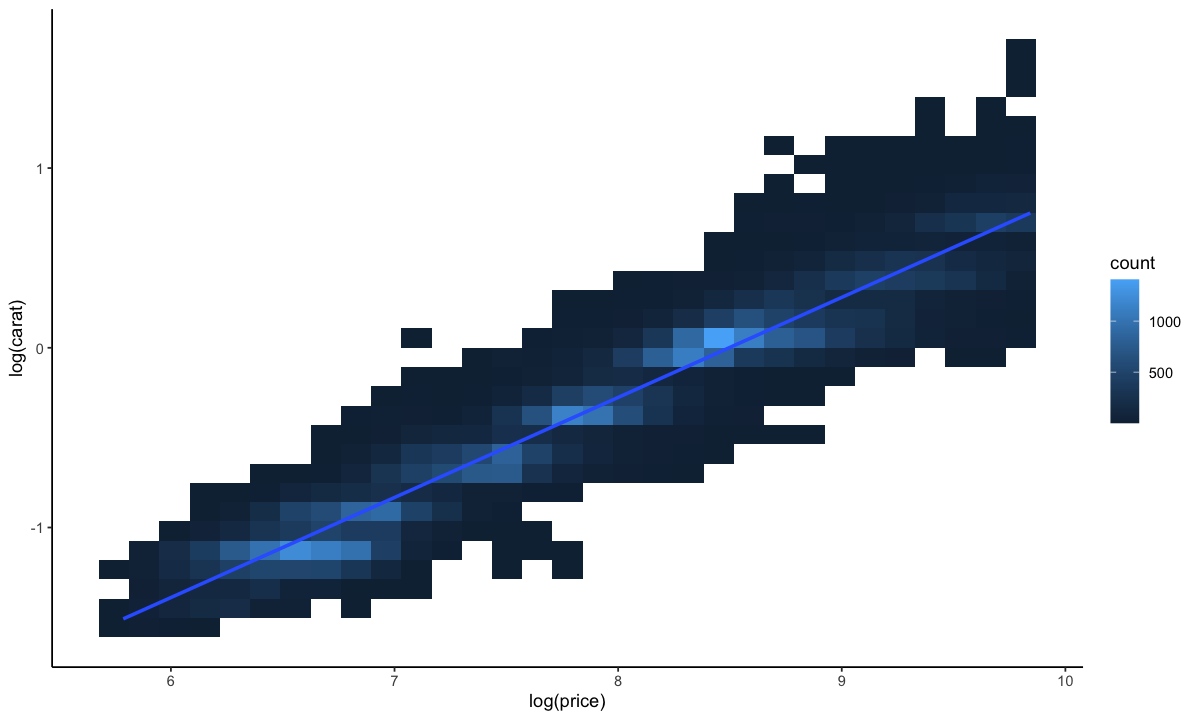

In [346]:
# example
ggplot(diamonds, aes(x=log(price), y=log(carat))) + geom_bin2d() + geom_smooth(method="lm")

- Suppose we want to predict the categorical variable `X_flare`. In other words, we want to find a function

$$f(\text{flux}_1,\text{flux}_2) \to \{\text{TRUE},\text{FALSE}\}$$

- How do we estimate such a function when the outcome is binary?

Let's try using the linear model first.

In [349]:
mdl <- lm(X_flare ~ ., data=cls_df) 
summary(mdl)


Call:
lm(formula = X_flare ~ ., data = cls_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68228 -0.01549 -0.00445 -0.00130  0.99373 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.167e-03  1.981e-03   0.589    0.556    
flux1        2.482e+04  1.318e+03  18.836   <2e-16 ***
flux2       -2.820e+03  3.744e+03  -0.753    0.451    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1148 on 3768 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1152,	Adjusted R-squared:  0.1148 
F-statistic: 245.4 on 2 and 3768 DF,  p-value: < 2.2e-16


R did not generate any errors. But the regression looks "weird" in many ways:
- The $R$-squared low.
- The residual standard error is large relative to the outcome (which is always either zero or one).
- The residuals look weird:

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


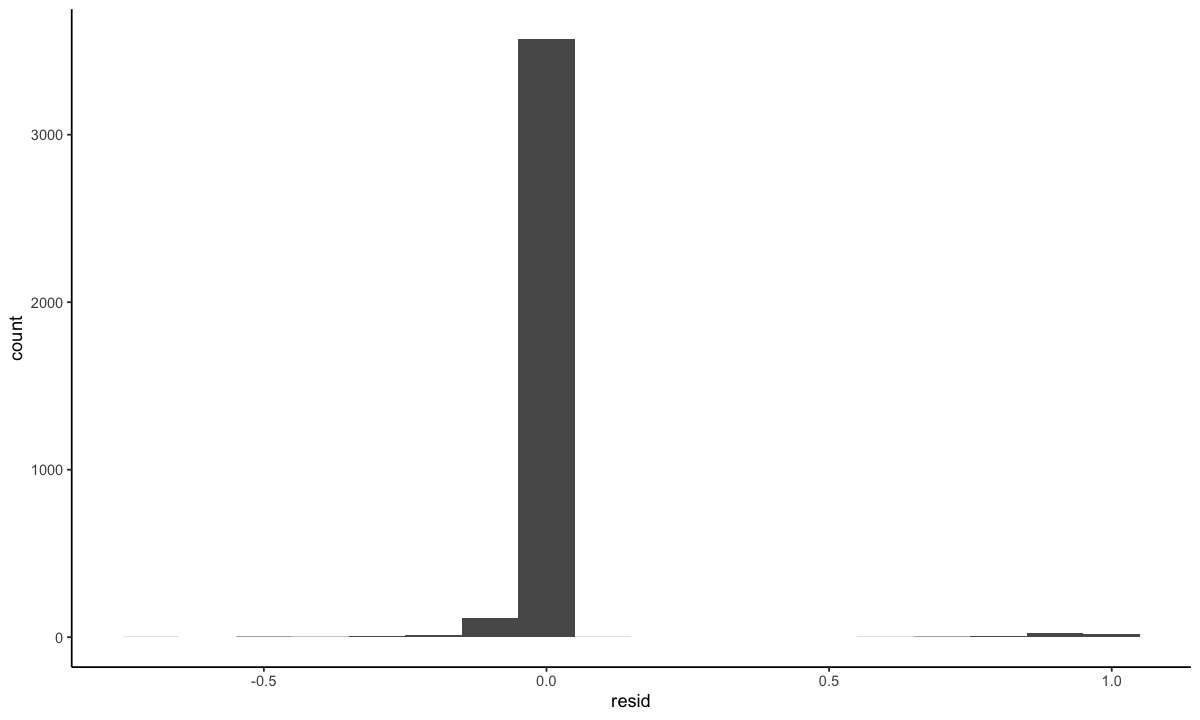

In [350]:
cls_df %>% add_residuals(mdl) %>% 
    ggplot + geom_histogram(aes(x=resid), binwidth=.1)

Compare with the residuals from a good fitting linear regression!:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


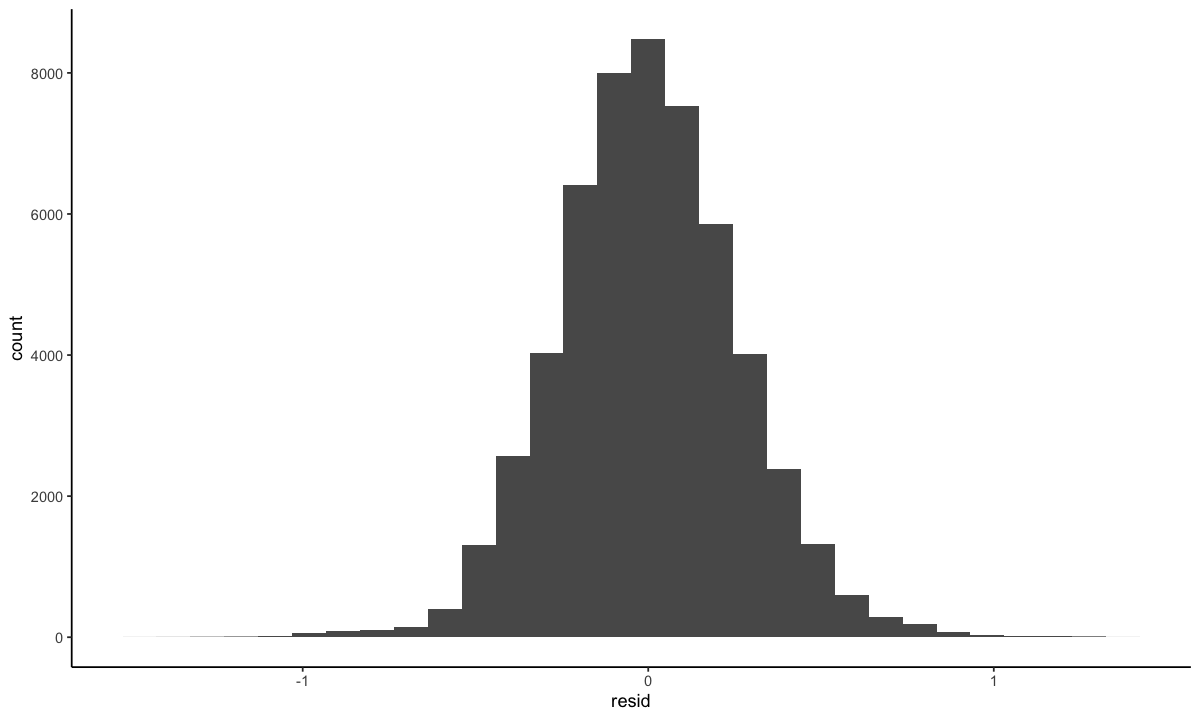

In [351]:
lm(log(price) ~ log(carat), data=diamonds) %>% add_residuals(diamonds, .) %>%
    ggplot + geom_histogram(aes(x=resid))

What about predictions? The predicted outcomes are decimal numbers, whereas in the original model, the outcome was `TRUE` or `FALSE`.

In [353]:
cls_df %>% add_predictions(mdl) %>% head

X_flare,flux1,flux2,pred
<lgl>,<dbl>,<dbl>,<dbl>
TRUE,NA,NA,NA
FALSE,2.322763e-06,4.807203e-07,0.05747074
FALSE,4.118884e-07,1.955416e-08,0.01133630
FALSE,3.971638e-07,1.906986e-08,0.01097215
FALSE,3.723984e-07,2.424830e-08,0.01034278
FALSE,1.297508e-07,9.258739e-09,0.00436164


The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero one one.

A function which satisfies both the properties is the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

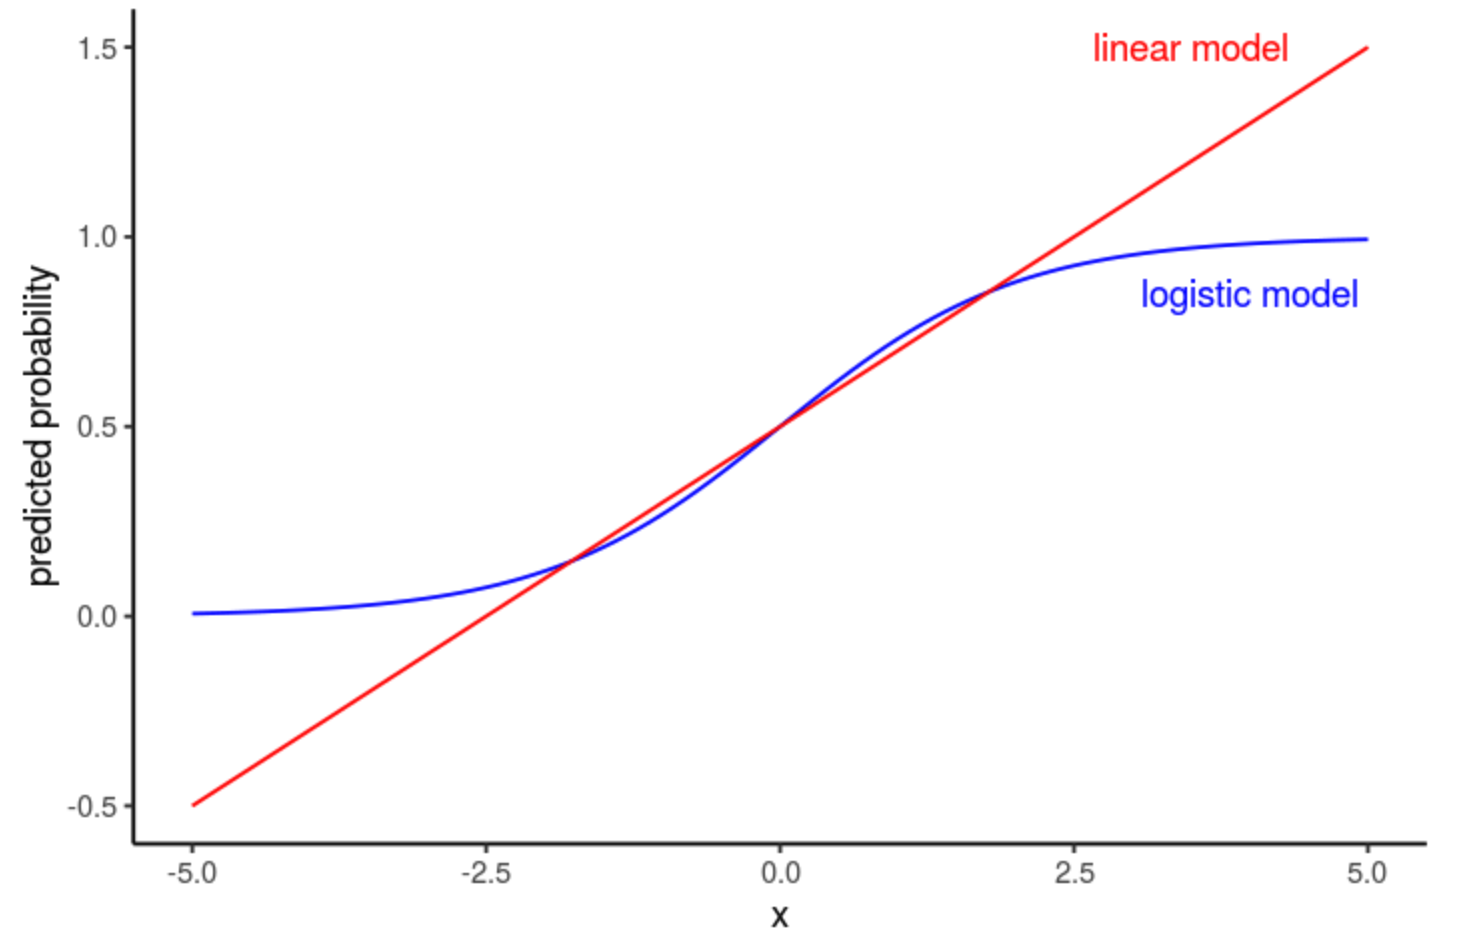

To fit this model in R, we use a similar command as for linear regression: `glm()`. (The "g" stands for **g**eneralized linear model.)

In [358]:
gmdl <- glm(X_flare ~ ., data = cls_df)
summary(gmdl)


Call:
glm(formula = X_flare ~ ., data = cls_df)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.167e-03  1.981e-03   0.589    0.556    
flux1        2.482e+04  1.318e+03  18.836   <2e-16 ***
flux2       -2.820e+03  3.744e+03  -0.753    0.451    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.01318203)

    Null deviance: 56.138  on 3770  degrees of freedom
Residual deviance: 49.670  on 3768  degrees of freedom
  (1 observation deleted due to missingness)
AIC: -5617.7

Number of Fisher Scoring iterations: 2


In [360]:
cls_df %>% add_predictions(gmdl) %>% head

X_flare,flux1,flux2,pred
<lgl>,<dbl>,<dbl>,<dbl>
TRUE,NA,NA,NA
FALSE,2.322763e-06,4.807203e-07,0.05747074
FALSE,4.118884e-07,1.955416e-08,0.01133630
FALSE,3.971638e-07,1.906986e-08,0.01097215
FALSE,3.723984e-07,2.424830e-08,0.01034278
FALSE,1.297508e-07,9.258739e-09,0.00436164


## Model selection
- Now we are going to try and build a good classifier for the X_flare prediction task.
- `tidymodels` is a collection of packages for machine learning and data modeling. 
- It automates the process of model fitting and testing.

In [212]:
library(tidymodels)

- Next, we split the data into training and testing sets.
- The default train/test split is 75% for training and 25% for testing, but this can be adjusted.
- The classification algorithm requires the output variable to be a factor, so we convert `X_flare` from numeric to factor.

In [373]:
set.seed(1)
split <- cls_df %>% mutate(X_flare = factor(X_flare)) %>% initial_split
train <- training(split)
test <- testing(split)

### Creating a recipe.
- Before modeling, we need to preprocess our predictors.
- Tidymodels packages this all up into a "recipe" (think pipeline).
- We use a "recipe" to normalize all predictor variables. This is important because it ensures that all our predictors are on the same scale, preventing variables with larger scales from dominating the model.


In [375]:
recipe <- recipe(X_flare ~ ., data = train) %>% 
    step_normalize(all_predictors())


In [376]:
recipe



── Recipe ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering and scaling for: all_predictors()



- Now, let's define our model. We'll start with a logistic regression model. This is standard for binary classification prolbems.
- We set the engine to `glm` (Generalized Linear Model) and specify that we're performing classification.
- (`glm` is in base R. Other faster libraries exist for binary classification but this suffices for our purposes.)

In [377]:
model_spec <- logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification")

In [378]:
model_spec

Logistic Regression Model Specification (classification)

Computational engine: glm 


- With our recipe and model specification ready, we combine them into a workflow.
- Think of the workflow as a container that holds everything our model needs to run: preprocessing steps and the model itself.

In [379]:
# Workflow
workflow <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(model_spec)

In [380]:
workflow

══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Computational engine: glm 


- It's time to fit our model to the training data.
- This step "trains" the model, teaching it to predict the outcome variable from the predictors.


In [381]:
fit <- workflow %>% fit(data = train)

- After training, we evaluate our model's performance on the test set.
- This involves predicting the `X_flare` variable for the test data and comparing these predictions to the actual outcomes.

In [382]:
results <- fit %>%
  predict(new_data = test) %>%
  bind_cols(test) %>%
  metrics(truth = X_flare, estimate = .pred_class)

Here are the results:

In [383]:
print(results)

# A tibble: 2 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary       0.980  
2 kap      binary      -0.00674


Is this a good result? The fraction of X_type in the test data is: 

In [384]:
summary(test$X_flare)
1 - 15/928

FALSE  TRUE 
  928    15

[1] 0.9838362

So, simply guessing `FALSE` every time gets .986 accuracy. Our model is worse than that! A better measure of accuracy in this case is the (area under) the ROC curve.

### ROC curve
The output of logistic regression is a set of _probabilities_ (numbers between 0 and 1), whereas the observed value is either 0 or 1. To convert from probabilities to prediction of 0 or 1, most of use would probably use the common sense rule

> Predict that X_flare=TRUE if the predicted probability is > 1/2.

However, this is but one of many possibly classification rules. Another one could be:

> Predict that X_flare=TRUE if the predicted probability is > 0.

How would we expect this rule to perform? (Think in terms of false positive/false negative).

To evaluate our classifier we'll think about two measures:

- True positive rate (TPR): The percentage of days where an X-class flare was predicted, and one actually happened.
- False positive rate (FPR): The percentage of days where an X-class flare was predicted, but one did *not* happen.

- A classifier which gets TPR $\approx 1$ is highly "sensitive". 
- A classifier which gets FPR $\approx 0$ is highly "specific". 
- A classifier which gets $\text{TPR}\approx 1,\text{FPR}\approx 0$ is doing great!
- We can always achieve $\text{FPR}=0,\text{TPR}=0$ (how?)
- We can always achieve $\text{FPR}=1,\text{TPR}=1$ (how?)

From the preceding discussion, we see that, given any probabilistic classifier, we can always make it have $\text{FPR}=\text{TPR}=1$ or $\text{FPR}=\text{TPR}=0$ by choosing an extreme probability cutoff. In other words, there is a tradeoff between having a good (i.e. close to zero) false-positive rate and a good (i.e. close to 1) true positive rate.

The ROC curve is a visual summary of this tradeoff. It plots the false positive rate on the $x$-axis, and the true positive rate on the $y$ axis. 

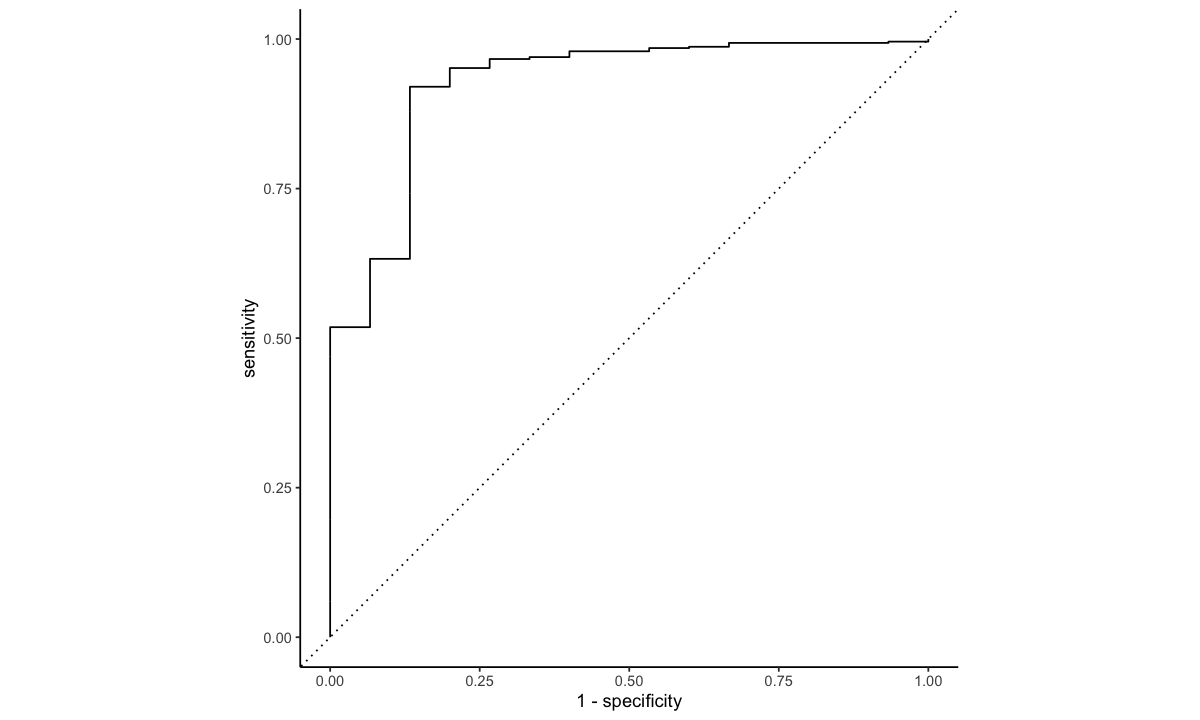

In [300]:
test %>% add_predictions(fit, type='prob') %>% unnest(pred) %>% 
    roc_curve(X_flare, .pred_FALSE) %>%
    autoplot + theme_classic()

## Area under curve
A useful single-digit summary of the ROC curve is called "area under curve". 
- AUC=1 equals perfect classifier.
- AUC=.5 equals random guessing (for balanced classes).
- AUC should never be below 0.5 (why?)


In [257]:
test %>% add_predictions(fit, type='prob') %>% unnest(pred) %>% 
    roc_auc(X_flare, .pred_FALSE)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9239943


## Improving the classifier
How can we improve the performance of our classifier?
- Add more predictors? (Get more data)
- Transform the existing predictors?

In [327]:
recipe_aug <- recipe(X_flare ~ ., data = train) %>% 
    step_log(flux1:flux2) %>% 
    step_lag(all_predictors(), lag=1) %>% 
    step_normalize(all_predictors())

In [328]:
# Workflow
fit_aug <- workflow() %>%
  add_recipe(recipe_aug) %>%
  add_model(model_spec) %>% 
  fit(data = train)

fit_aug %>%
  predict(new_data = test) %>%
  bind_cols(test) %>%
  metrics(truth = X_flare, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.979830149
kap,binary,-0.006749916


In [329]:
test %>% add_predictions(fit_aug, type='prob') %>% unnest(pred) %>% 
    roc_auc(X_flare, .pred_FALSE)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9373607
